In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import nltk
import nltk as nlp
import string
import re

In [2]:
import sys
!{sys.executable} -m pip install spacy

In [3]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

In [4]:
!{sys.executable} -m pip install psycopg2

In [4]:
import psycopg2
conn = psycopg2.connect(dbname='vknews', user='postgres', 
                        password='password', host='172.17.0.2')
cursor = conn.cursor()

In [5]:
cursor.execute('SELECT * FROM groups')
records = cursor.fetchall()
groups = list(records)
groups

[(76982440, 'meduzaproject', '«Медуза»', 713584),
 (15755094, 'ria', 'РИА Новости', 2503096),
 (23482909, 'kommersant_ru', 'Коммерсантъ', 329574),
 (28261334, 'tj', 'TJ', 702539),
 (25232578, 'rbc', 'РБК', 767882)]

In [6]:
groups_df = pd.DataFrame({
    'name': [group[2] for group in groups],
    'screen_name': [group[1] for group in groups],
    'members_count': [group[3] for group in groups]
})
groups_df

,name,screen_name,members_count
0,«Медуза»,meduzaproject,713584
1,РИА Новости,ria,2503096
2,Коммерсантъ,kommersant_ru,329574
3,TJ,tj,702539
4,РБК,rbc,767882


In [7]:
cursor.execute('SELECT * FROM posts')
records = cursor.fetchall()
posts = list(records)
len(posts)

1230

In [8]:
posts[0]

(1719061,
 'kommersant_ru',
 datetime.datetime(2020, 6, 15, 13, 0, 42),
 '«Вновь обрести Францию»',
 'Президент Эмманюэль Макрон анонсировал план выхода из кризиса',
 8,
 3207,
 2,
 1)

In [24]:
title_list = [post[3] for post in posts]
text_list = [post[4] for post in posts]

In [25]:
news = pd.DataFrame(data={'title': title_list, 'text': text_list})
news

,title,text
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...
1,Откопалипсис сегодня,В сети вышли «Пятеро одной крови» Спайка Ли
2,У снайпера проявились недетские чувства,Морпеха осудили за сексуальные действия на «гр...
3,Голикова: пик заражения COVID-19 в России приш...,Подробнее на сайте
4,Член псковского избиркома предложила застрахов...,Член избирательной комиссии Псковской области ...
...,...,...
1225,Что смотреть подросткам и с подростками: «Четы...,В рубрике «Домашний кинотеатр» «Медуза» расска...
1226,"«Суду нужно совершить ритуал, жертвоприношение...",17 июня в Петербурге начинаются судебные прени...
1227,"Всем интересно, где же будут «мужские разборки...",15 июня спортсмен Евгений Плющенко и оппозицио...
1228,Схиигумен Сергий ответил на обвинения в захват...,Схиигумен Сергий (Сергей Романов) ответил на о...


In [26]:
def unique(text):
    for word in text:
        text = text.split()
        text = set(text)
        return text
unique("i am going and i will go by bus")

{'am', 'and', 'bus', 'by', 'go', 'going', 'i', 'will'}

In [27]:
news['title_unq'] = news['title'].apply(lambda x: unique(x))
news.head(1)

,title,text,title_unq
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...,"{обрести, «Вновь, Францию»}"


In [28]:
def remove_numbers(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text
remove_numbers("I am 20 years")

'I am  years'

In [29]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL("Kaggle id https://www.kaggle.com/vanshjatana")

'Kaggle id '

In [30]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
remove_html("<h1>Vansh Jatana</h1>")

'Vansh Jatana'

In [31]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Sad😔")

'Sad'

In [32]:
!{sys.executable} -m pip install pymorphy2

In [34]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

pattern = re.compile(r'\W')
def pos(word, morth=pymorphy2.MorphAnalyzer()):
    "Return a likely part of speech for the *word*."""
    return morth.parse(word)[0].tag.POS

functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'}  # function words
print('Without pretext:')
words = [pattern.sub('', word) for word in title_list[0].split() if pos(word) not in functors_pos]
print(*words)
print('Normal forms:')
words = [morph.normal_forms(w)[0] for w in words]
print(' '.join(words))

Without pretext:
Вновь обрести Францию
Normal forms:
вновь обрести франция


In [65]:
pattern = re.compile(r'\W')
notdigit = re.compile(r'\D')

def text_pipeline(text: str) -> list:
    morph = pymorphy2.MorphAnalyzer()
    functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'}  # function words
    pos = lambda word: morph.parse(word)[0].tag.POS
    words = [pattern.sub('', word) for word in text.split() if pos(word) not in functors_pos]
    words = [word for word in words if notdigit.match(word)]
    words = [morph.normal_forms(w)[0] for w in words]
    return ' '.join(words)

text_pipeline('Бизнесмена из «списка Титова» вопреки обещания посадили на 20 суток.')

'бизнесмен список титов обещание посадить сутки'

In [58]:
!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator

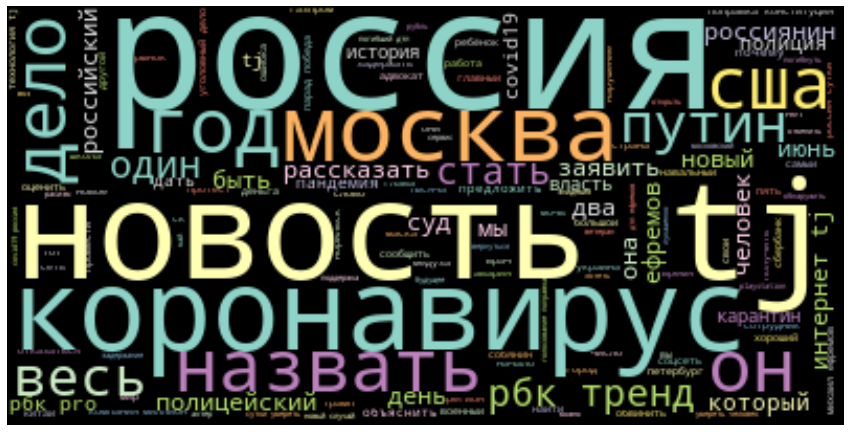

In [67]:
text = ''
for title in title_list:
    title = text_pipeline(title)
    text += title + ' '
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

In [68]:
group_list = [post[1] for post in posts]
news['group'] = group_list
news

,title,text,title_unq,group,likes_count,views_count,comments_count,reposts_count,likes_to_views,processed_title
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...,"{обрести, «Вновь, Францию»}",kommersant_ru,8,3207,2,1,0.002495,новь обрести францию»
1,Откопалипсис сегодня,В сети вышли «Пятеро одной крови» Спайка Ли,"{Откопалипсис, сегодня}",kommersant_ru,5,2562,0,2,0.001952,откопалипсис сегодня
2,У снайпера проявились недетские чувства,Морпеха осудили за сексуальные действия на «гр...,"{снайпера, У, проявились, недетские, чувства}",kommersant_ru,7,3214,1,1,0.002178,снайпер проявиться недетский чувство
3,Голикова: пик заражения COVID-19 в России приш...,Подробнее на сайте,"{на, в, пик, COVID-19, Голикова:, заражения, п...",kommersant_ru,9,5501,8,0,0.001636,голикова: пик заражение covid-19 россия прийти...
4,Член псковского избиркома предложила застрахов...,Член избирательной комиссии Псковской области ...,"{псковского, Член, застраховать, избиркома, на...",meduzaproject,86,34631,36,4,0.002483,член псковский избирком предложить застраховат...
...,...,...,...,...,...,...,...,...,...,...
1225,Что смотреть подросткам и с подростками: «Четы...,В рубрике «Домашний кинотеатр» «Медуза» расска...,"{детстве, «Джуно», фильмов, смотреть, и, перво...",meduzaproject,158,36587,27,21,0.004318,смотреть подросток подростками: етырест удар у...
1226,"«Суду нужно совершить ритуал, жертвоприношение...",17 июня в Петербурге начинаются судебные прени...,"{обвиняемого, «Суду, еще, В, Бояршиновым, отцо...",meduzaproject,60,23647,13,3,0.002537,"уд нужно совершить ритуал, жертвоприношение» п..."
1227,"Всем интересно, где же будут «мужские разборки...",15 июня спортсмен Евгений Плющенко и оппозицио...,"{жаль, всем, же, Навального, гаражами?, Всем, ...",meduzaproject,214,41972,81,4,0.005099,"весь интересно, где быть ужский разборки» нава..."
1228,Схиигумен Сергий ответил на обвинения в захват...,Схиигумен Сергий (Сергей Романов) ответил на о...,"{обвинения, ответил, Сергий, на, монастыря, в,...",ria,41,21479,65,2,0.001909,схиигумен сергий ответить обвинение захват мон...


In [69]:
news['likes_count'] = [post[5] for post in posts]
news['views_count'] = [post[6] for post in posts]
news['comments_count'] = [post[7] for post in posts]
news['reposts_count'] = [post[8] for post in posts]
news

,title,text,title_unq,group,likes_count,views_count,comments_count,reposts_count,likes_to_views,processed_title
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...,"{обрести, «Вновь, Францию»}",kommersant_ru,8,3207,2,1,0.002495,новь обрести францию»
1,Откопалипсис сегодня,В сети вышли «Пятеро одной крови» Спайка Ли,"{Откопалипсис, сегодня}",kommersant_ru,5,2562,0,2,0.001952,откопалипсис сегодня
2,У снайпера проявились недетские чувства,Морпеха осудили за сексуальные действия на «гр...,"{снайпера, У, проявились, недетские, чувства}",kommersant_ru,7,3214,1,1,0.002178,снайпер проявиться недетский чувство
3,Голикова: пик заражения COVID-19 в России приш...,Подробнее на сайте,"{на, в, пик, COVID-19, Голикова:, заражения, п...",kommersant_ru,9,5501,8,0,0.001636,голикова: пик заражение covid-19 россия прийти...
4,Член псковского избиркома предложила застрахов...,Член избирательной комиссии Псковской области ...,"{псковского, Член, застраховать, избиркома, на...",meduzaproject,86,34631,36,4,0.002483,член псковский избирком предложить застраховат...
...,...,...,...,...,...,...,...,...,...,...
1225,Что смотреть подросткам и с подростками: «Четы...,В рубрике «Домашний кинотеатр» «Медуза» расска...,"{детстве, «Джуно», фильмов, смотреть, и, перво...",meduzaproject,158,36587,27,21,0.004318,смотреть подросток подростками: етырест удар у...
1226,"«Суду нужно совершить ритуал, жертвоприношение...",17 июня в Петербурге начинаются судебные прени...,"{обвиняемого, «Суду, еще, В, Бояршиновым, отцо...",meduzaproject,60,23647,13,3,0.002537,"уд нужно совершить ритуал, жертвоприношение» п..."
1227,"Всем интересно, где же будут «мужские разборки...",15 июня спортсмен Евгений Плющенко и оппозицио...,"{жаль, всем, же, Навального, гаражами?, Всем, ...",meduzaproject,214,41972,81,4,0.005099,"весь интересно, где быть ужский разборки» нава..."
1228,Схиигумен Сергий ответил на обвинения в захват...,Схиигумен Сергий (Сергей Романов) ответил на о...,"{обвинения, ответил, Сергий, на, монастыря, в,...",ria,41,21479,65,2,0.001909,схиигумен сергий ответить обвинение захват мон...


In [70]:
news['likes_to_views'] = news['likes_count'] / news['views_count']
news['processed_title'] = [text_pipeline(title) for title in news['title']]
news

,title,text,title_unq,group,likes_count,views_count,comments_count,reposts_count,likes_to_views,processed_title
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...,"{обрести, «Вновь, Францию»}",kommersant_ru,8,3207,2,1,0.002495,вновь обрести франция
1,Откопалипсис сегодня,В сети вышли «Пятеро одной крови» Спайка Ли,"{Откопалипсис, сегодня}",kommersant_ru,5,2562,0,2,0.001952,откопалипсис сегодня
2,У снайпера проявились недетские чувства,Морпеха осудили за сексуальные действия на «гр...,"{снайпера, У, проявились, недетские, чувства}",kommersant_ru,7,3214,1,1,0.002178,снайпер проявиться недетский чувство
3,Голикова: пик заражения COVID-19 в России приш...,Подробнее на сайте,"{на, в, пик, COVID-19, Голикова:, заражения, п...",kommersant_ru,9,5501,8,0,0.001636,голиков пик заражение covid19 россия прийтись май
4,Член псковского избиркома предложила застрахов...,Член избирательной комиссии Псковской области ...,"{псковского, Член, застраховать, избиркома, на...",meduzaproject,86,34631,36,4,0.002483,член псковский избирком предложить застраховат...
...,...,...,...,...,...,...,...,...,...,...
1225,Что смотреть подросткам и с подростками: «Четы...,В рубрике «Домашний кинотеатр» «Медуза» расска...,"{детстве, «Джуно», фильмов, смотреть, и, перво...",meduzaproject,158,36587,27,21,0.004318,смотреть подросток подросток четыреста удар чу...
1226,"«Суду нужно совершить ритуал, жертвоприношение...",17 июня в Петербурге начинаются судебные прени...,"{обвиняемого, «Суду, еще, В, Бояршиновым, отцо...",meduzaproject,60,23647,13,3,0.002537,суд нужно совершить ритуал жертвоприношение пе...
1227,"Всем интересно, где же будут «мужские разборки...",15 июня спортсмен Евгений Плющенко и оппозицио...,"{жаль, всем, же, Навального, гаражами?, Всем, ...",meduzaproject,214,41972,81,4,0.005099,весь интересно где быть мужской разборка навал...
1228,Схиигумен Сергий ответил на обвинения в захват...,Схиигумен Сергий (Сергей Романов) ответил на о...,"{обвинения, ответил, Сергий, на, монастыря, в,...",ria,41,21479,65,2,0.001909,схиигумен сергий ответить обвинение захват мон...


In [71]:
from sklearn.feature_extraction.text import CountVectorizer
print('Text len: ', len(text))
vectorizer = CountVectorizer()
vectorizer.fit([text])
print('Vocabulary len: ', len(vectorizer.vocabulary_), '\n', list(vectorizer.vocabulary_.items())[:10], sep='')

Text len:  78500
Vocabulary len: 3537
[('вновь', 486), ('обрести', 1814), ('франция', 3331), ('откопалипсис', 1955), ('сегодня', 2766), ('снайпер', 2868), ('проявиться', 2499), ('недетский', 1700), ('чувство', 3431), ('голиков', 689)]


In [72]:
sorted_d = {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True)}
list(sorted_d.items())[:10]

[('ясный', 3536),
 ('ясно', 3535),
 ('японец', 3534),
 ('яндекстелемост', 3533),
 ('яндекстакси', 3532),
 ('яндекскуколд', 3531),
 ('яндекседа', 3530),
 ('яндекс', 3529),
 ('ям', 3528),
 ('якутск', 3527)]

In [73]:
counts = [item[1] for item in sorted_d.items()]
print('Len: ', len(counts), '\n', counts[:10], sep='')

Len: 3537
[3536, 3535, 3534, 3533, 3532, 3531, 3530, 3529, 3528, 3527]


In [74]:
labels = [item[0] for item in sorted_d.items()]
print('Len: ', len(labels), '\n', labels[:10], sep='')

Len: 3537
['ясный', 'ясно', 'японец', 'яндекстелемост', 'яндекстакси', 'яндекскуколд', 'яндекседа', 'яндекс', 'ям', 'якутск']


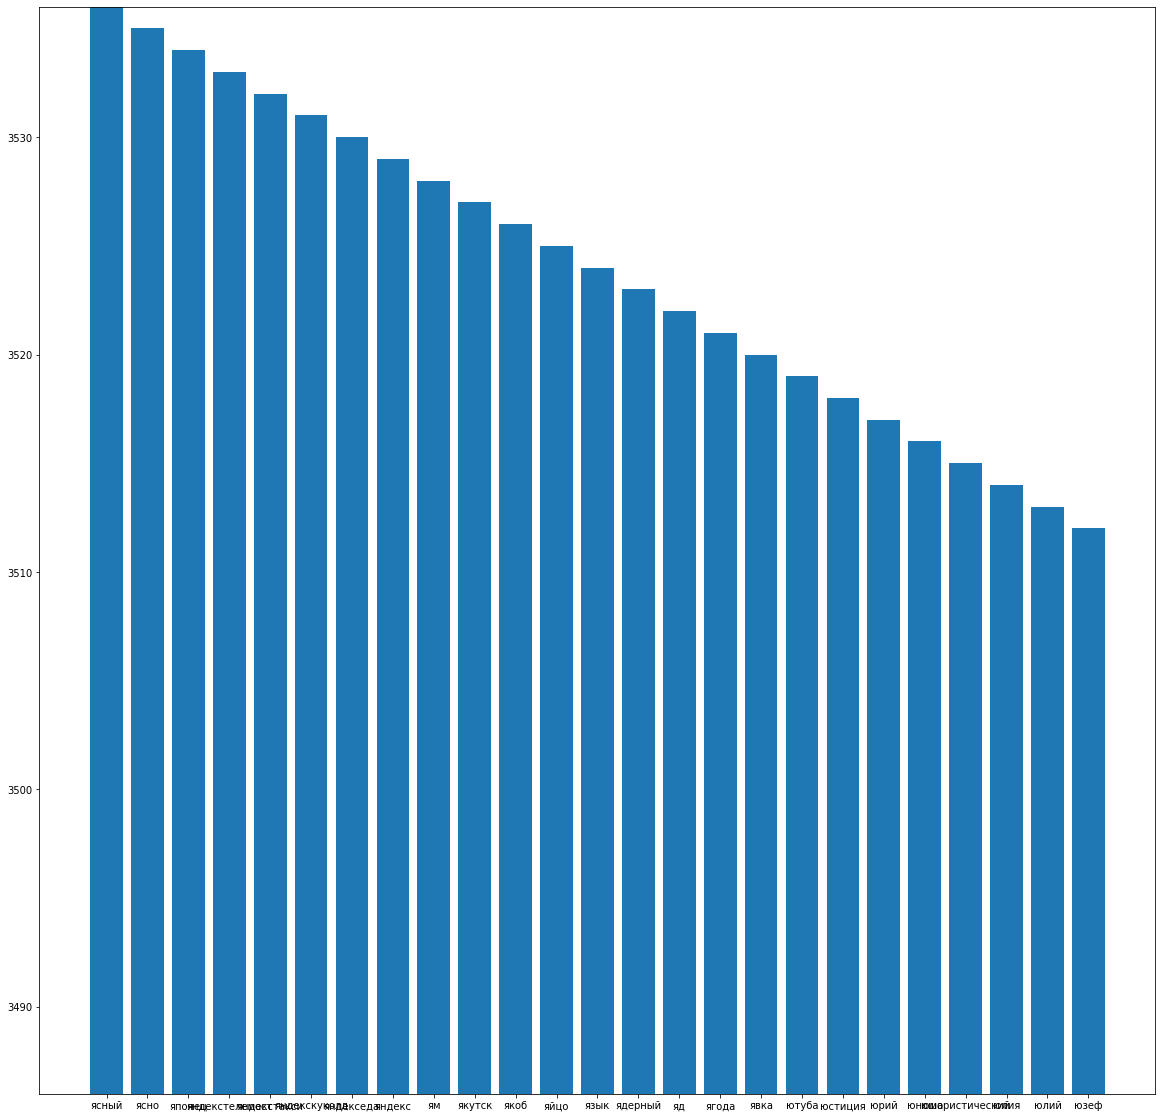

In [75]:
COUNT = 25
plt.subplots(figsize=(20,20))
plt.bar(range(len(counts[:COUNT])), counts[:COUNT])
plt.xticks(range(len(counts[:COUNT])), tuple(labels[:COUNT]))
plt.ylim(ymax = counts[0], ymin = counts[COUNT * 2])
plt.show()

In [76]:
news['processed_title'][0]

'вновь обрести франция'

In [77]:
vectorized_title = vectorizer.transform(news['processed_title'])
vectorized_title

<1230x3537 sparse matrix of type '<class 'numpy.int64'>'
	with 9637 stored elements in Compressed Sparse Row format>

In [78]:
print(len(vectorizer.vocabulary_))

3537


In [79]:
for i, col in enumerate(vectorizer.get_feature_names()):
    news[col] = pd.Series(pd.arrays.SparseArray(vectorized_title[:, i].toarray().ravel(), fill_value=0))
news

,title,text,title_unq,group,likes_count,views_count,comments_count,reposts_count,likes_to_views,processed_title,...,якутск,ям,яндекс,яндекседа,яндекскуколд,яндекстакси,яндекстелемост,японец,ясно,ясный
0,«Вновь обрести Францию»,Президент Эмманюэль Макрон анонсировал план вы...,"{обрести, «Вновь, Францию»}",0,8,3207,2,1,0.002495,вновь обрести франция,...,0,0,0,0,0,0,0,0,0,0
1,Откопалипсис сегодня,В сети вышли «Пятеро одной крови» Спайка Ли,"{Откопалипсис, сегодня}",0,5,2562,0,2,0.001952,откопалипсис сегодня,...,0,0,0,0,0,0,0,0,0,0
2,У снайпера проявились недетские чувства,Морпеха осудили за сексуальные действия на «гр...,"{снайпера, У, проявились, недетские, чувства}",0,7,3214,1,1,0.002178,снайпер проявиться недетский чувство,...,0,0,0,0,0,0,0,0,0,0
3,Голикова: пик заражения COVID-19 в России приш...,Подробнее на сайте,"{на, в, пик, COVID-19, Голикова:, заражения, п...",0,9,5501,8,0,0.001636,голиков пик заражение covid19 россия прийтись май,...,0,0,0,0,0,0,0,0,0,0
4,Член псковского избиркома предложила застрахов...,Член избирательной комиссии Псковской области ...,"{псковского, Член, застраховать, избиркома, на...",0,86,34631,36,4,0.002483,член псковский избирком предложить застраховат...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,Что смотреть подросткам и с подростками: «Четы...,В рубрике «Домашний кинотеатр» «Медуза» расска...,"{детстве, «Джуно», фильмов, смотреть, и, перво...",0,158,36587,27,21,0.004318,смотреть подросток подросток четыреста удар чу...,...,0,0,0,0,0,0,0,0,0,0
1226,"«Суду нужно совершить ритуал, жертвоприношение...",17 июня в Петербурге начинаются судебные прени...,"{обвиняемого, «Суду, еще, В, Бояршиновым, отцо...",0,60,23647,13,3,0.002537,суд нужно совершить ритуал жертвоприношение пе...,...,0,0,0,0,0,0,0,0,0,0
1227,"Всем интересно, где же будут «мужские разборки...",15 июня спортсмен Евгений Плющенко и оппозицио...,"{жаль, всем, же, Навального, гаражами?, Всем, ...",0,214,41972,81,4,0.005099,весь интересно где быть мужской разборка навал...,...,0,0,0,0,0,0,0,0,0,0
1228,Схиигумен Сергий ответил на обвинения в захват...,Схиигумен Сергий (Сергей Романов) ответил на о...,"{обвинения, ответил, Сергий, на, монастыря, в,...",0,41,21479,65,2,0.001909,схиигумен сергий ответить обвинение захват мон...,...,0,0,0,0,0,0,0,0,0,0


In [80]:
news.iloc[:, 12:]

,amazon,androidсмартфон,app,apple,ar,aramco,badcomedian,band,bazaar,big,...,якутск,ям,яндекс,яндекседа,яндекскуколд,яндекстакси,яндекстелемост,японец,ясно,ясный
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
for column in news.columns[-20:]:
    print('Word: ', column)
    print('Likes: ', news[news[column]==1]['likes_count'].sum())
    print('Views: ', news[news[column]==1]['views_count'].sum())
    print('Comments: ', news[news[column]==1]['comments_count'].sum())
    print('Reposts: ', news[news[column]==1]['reposts_count'].sum(), end='\n\n')

Word:  юрий
Likes:  180
Views:  61313
Comments:  77
Reposts:  6

Word:  юстиция
Likes:  73
Views:  37196
Comments:  42
Reposts:  3

Word:  ютуба
Likes:  92
Views:  21084
Comments:  30
Reposts:  3

Word:  явка
Likes:  2
Views:  3044
Comments:  1
Reposts:  0

Word:  ягода
Likes:  3
Views:  2249
Comments:  0
Reposts:  0

Word:  яд
Likes:  119
Views:  77567
Comments:  75
Reposts:  5

Word:  ядерный
Likes:  26
Views:  17974
Comments:  49
Reposts:  2

Word:  язык
Likes:  284
Views:  104632
Comments:  556
Reposts:  7

Word:  яйцо
Likes:  212
Views:  42609
Comments:  9
Reposts:  17

Word:  якоб
Likes:  0
Views:  1077
Comments:  0
Reposts:  0

Word:  якутск
Likes:  239
Views:  32778
Comments:  19
Reposts:  2

Word:  ям
Likes:  168
Views:  33970
Comments:  21
Reposts:  4

Word:  яндекс
Likes:  337
Views:  116679
Comments:  238
Reposts:  8

Word:  яндекседа
Likes:  6
Views:  2691
Comments:  0
Reposts:  1

Word:  яндекскуколд
Likes:  138
Views:  32629
Comments:  152
Reposts:  0

Word:  яндекстакси

In [48]:
words_df = pd.DataFrame({
        'word': [],
        'likes': [],
        'views': [],
        'comments': [],
        'reposts': []
    })
words_df

,word,likes,views,comments,reposts


In [56]:
for column in news.columns[12:]:
    row = {
        'word': column,
        'likes': news[news[column]==1]['likes_count'].sum(),
        'views': news[news[column]==1]['views_count'].sum(),
        'comments': news[news[column]==1]['comments_count'].sum(),
        'reposts': news[news[column]==1]['reposts_count'].sum()
    }
    for group in groups_df.iterrows():
        row[group[1][0]] = len(news[(news[column]==1) & (news['group']==group[1][1])]) 
    words_df = words_df.append(row, ignore_index=True)
words_df

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости
0,10,300.0,90245.0,159.0,22.0,0.0,2.0,1.0,1.0,0.0
1,11,332.0,88043.0,68.0,3.0,1.0,1.0,2.0,1.0,0.0
2,12,266.0,84653.0,154.0,3.0,1.0,2.0,1.0,0.0,0.0
3,1200,100.0,25657.0,51.0,1.0,0.0,1.0,0.0,0.0,0.0
4,14,241.0,78474.0,138.0,7.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1807,яндекса,3.0,3038.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0
1808,яндекскуколд,477.0,85259.0,538.0,10.0,1.0,1.0,0.0,0.0,0.0
1809,яндексу,78.0,19850.0,35.0,1.0,0.0,0.0,1.0,1.0,0.0
1810,ясно,3.0,2451.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0


In [58]:
words_df['likes2views'] = words_df['likes'] / words_df['views']
words_df['comments2views'] = words_df['comments'] / words_df['views']
words_df

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости,likes2views,comments2views
0,10,300.0,90245.0,159.0,22.0,0.0,2.0,1.0,1.0,0.0,0.003324,0.001762
1,11,332.0,88043.0,68.0,3.0,1.0,1.0,2.0,1.0,0.0,0.003771,0.000772
2,12,266.0,84653.0,154.0,3.0,1.0,2.0,1.0,0.0,0.0,0.003142,0.001819
3,1200,100.0,25657.0,51.0,1.0,0.0,1.0,0.0,0.0,0.0,0.003898,0.001988
4,14,241.0,78474.0,138.0,7.0,0.0,2.0,0.0,0.0,0.0,0.003071,0.001759
...,...,...,...,...,...,...,...,...,...,...,...,...
1807,яндекса,3.0,3038.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000987,0.001317
1808,яндекскуколд,477.0,85259.0,538.0,10.0,1.0,1.0,0.0,0.0,0.0,0.005595,0.006310
1809,яндексу,78.0,19850.0,35.0,1.0,0.0,0.0,1.0,1.0,0.0,0.003929,0.001763
1810,ясно,3.0,2451.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.001224,0.001224


In [62]:
words_df = words_df.dropna()

In [64]:
# Most liked are news with words below in title
words_df.sort_values(by=['likes2views'], ascending=False).head(10)

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости,likes2views,comments2views
796,москвичу,598.0,45091.0,165.0,28.0,0.0,1.0,0.0,0.0,0.0,0.013262,0.003659
1733,хочешь,598.0,45091.0,165.0,28.0,0.0,1.0,0.0,0.0,0.0,0.013262,0.003659
1408,себя,599.0,48041.0,168.0,28.0,0.0,1.0,1.0,0.0,0.0,0.012469,0.003497
1072,подбросить,943.0,76000.0,258.0,43.0,1.0,1.0,0.0,0.0,0.0,0.012408,0.003395
363,громко,943.0,76000.0,258.0,43.0,1.0,1.0,0.0,0.0,0.0,0.012408,0.003395
34,720,437.0,37709.0,45.0,14.0,0.0,1.0,0.0,0.0,0.0,0.011589,0.001193
1698,фбк,437.0,37709.0,45.0,14.0,0.0,1.0,0.0,0.0,0.0,0.011589,0.001193
855,недвижимость,437.0,37709.0,45.0,14.0,0.0,1.0,0.0,0.0,0.0,0.011589,0.001193
1608,тот,345.0,30909.0,93.0,15.0,1.0,0.0,0.0,0.0,0.0,0.011162,0.003009
804,мужчине,345.0,30909.0,93.0,15.0,1.0,0.0,0.0,0.0,0.0,0.011162,0.003009


In [65]:
# Most discussed are news with words below in title
words_df.sort_values(by=['comments2views'], ascending=False).head(10)

,word,likes,views,comments,reposts,TJ,«Медуза»,Коммерсантъ,РБК,РИА Новости,likes2views,comments2views
534,извиняться,49.0,21241.0,244.0,6.0,0.0,0.0,0.0,0.0,1.0,0.002307,0.011487
408,доля,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
226,вдвое,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
1169,почти,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
177,безусловных,81.0,21338.0,235.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003796,0.011013
523,знать,63.0,37498.0,401.0,8.0,0.0,0.0,0.0,2.0,0.0,0.001680,0.010694
451,жесткие,101.0,27626.0,284.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003656,0.010280
224,ввести,101.0,27626.0,284.0,10.0,0.0,0.0,0.0,1.0,0.0,0.003656,0.010280
1167,похороны,17.0,20366.0,196.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000835,0.009624
1714,фоторепортаж,17.0,20366.0,196.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000835,0.009624


In [71]:
words_df[['likes', 'comments', 'reposts', 'views']].corr()

,likes,comments,reposts,views
likes,1.000000,0.903448,0.943461,0.977955
comments,0.903448,1.000000,0.938303,0.908972
reposts,0.943461,0.938303,1.000000,0.928201
views,0.977955,0.908972,0.928201,1.000000
